#Multi Modal (Morphometry+Connectome) GCN (AD v MCI)

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/My\ Drive/GCN_AD/GCN-17-master/src
!pip install dgl-cu100

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/GCN_AD/GCN-17-master/src


In [2]:
import sys, os
os.environ["DGLBACKEND"] = "pytorch"

#Argument Setup

In [3]:
import argparse, time
import numpy as np
from dgl.data import register_data_args, load_data

parser = argparse.ArgumentParser(description='GCN')
#register_data_args(parser)
parser.add_argument("--dropout", type=float, default=0.7,
        help="dropout probability")
parser.add_argument("--gpu", type=int, default= -1,
        help="gpu")
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--weight-decay", type=float, default=9e-4,
        help="Weight for L2 loss")
parser.add_argument("--fold", type=float, default=10,
        help="Weight for L2 loss")
parser.add_argument("--number_edges", type=int, default=10,
                    help="Graph: minimum number of edges per vertex.")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.set_defaults(self_loop=False)

args, unknown = parser.parse_known_args()
print(args)

Using backend: pytorch


Namespace(dropout=0.7, fold=10, gpu=-1, lr=0.001, n_epochs=100, number_edges=10, self_loop=False, weight_decay=0.0009)


#GCN Class Definition

In [4]:
"""GCN using DGL nn package
References:
- Semi-Supervised Classification with Graph Convolutional Networks
- Paper: https://arxiv.org/abs/1609.02907
- Code: https://github.com/tkipf/gcn
"""
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')
%matplotlib inline

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(200, 16)
        self.layer2 = GCNLayer(16, 2)
        
        # self.fc1 = nn.Linear(32,16)
        # self.fc2 = nn.Linear(16,2)
        
        #self.dropout1 = nn.Dropout(p=args.dropout, inplace=False)
    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        #x = self.dropout1(x)
        x = self.layer2(g, x)
        
        
        
        return x

net = Net()
print(net) 

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=200, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=2, bias=True)
  )
)


#Supporting Funcitons

In [5]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
    
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.gaussian_distance(z,k=args.number_edges, gamma = 0.5)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))
    print("{} > {} edges".format(A.nnz//2, args.number_edges*m**2//2))
    return A

#Load Connectome Data

In [6]:
import os 
import scipy.io
from scipy import stats
from __future__ import print_function


import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

test=scipy.io.loadmat('../idp_connectome_aparc_length.mat')
aparcl=np.array(test['connectome_aparc_length'])
print(aparcl.shape)

test=scipy.io.loadmat('../idp_connectome_aparc_count.mat')
aparcc=np.array(test['connectome_aparc_count'])
print(aparcc.shape)

test=scipy.io.loadmat('../idp_connectome_aparc2009_length.mat')
aparc2l=np.array(test['connectome_aparc2009_length'])
print(aparc2l.shape)

test=scipy.io.loadmat('../idp_connectome_aparc2009_count.mat')
aparc2c=np.array(test['connectome_aparc2009_count'])
print(aparc2c.shape)

(84, 84, 211)
(84, 84, 211)
(164, 164, 211)
(164, 164, 211)


Reshape for Appendage

In [7]:
aparcl = aparcl.transpose([2,0,1])
aparcc = aparcc.transpose([2,0,1])
aparc2l = aparc2l.transpose([2,0,1])
aparc2c = aparc2c.transpose([2,0,1])

print(aparcl.shape,aparcc.shape)
print(aparc2l.shape,aparc2c.shape)

aparcl = aparcl.reshape(211,-1)
aparcc = aparcc.reshape(211,-1)
aparc2l = aparc2l.reshape(211,-1)
aparc2c = aparc2c.reshape(211,-1)

print(aparcl.shape,aparcc.shape)
print(aparc2l.shape,aparc2c.shape)

X_1 = np.append(aparcl, aparcc, axis=1)
X_2 = np.append(aparc2l,aparc2c,axis=1)
X = np.append(X_1,X_2,axis=1)
print(X.shape)

(211, 84, 84) (211, 84, 84)
(211, 164, 164) (211, 164, 164)
(211, 7056) (211, 7056)
(211, 26896) (211, 26896)
(211, 67904)


Load Labels (Con.)

In [8]:
data=pd.read_csv('../idp_data_1_mor.csv',header=0)
data=np.array(data)
print(data.shape)
datasubjid=data[:,0]
print(datasubjid.shape)
matsubjid=pd.read_csv('../idp_connectome_subjectlist.csv',header=0)
matsubjid=np.array(matsubjid)
print(matsubjid.shape)

filtindex=np.isin(matsubjid,datasubjid)
filtindex=filtindex.ravel()
labels=data[:,1]
X = X[filtindex]
y=labels
print(y.shape)

(208, 959)
(208,)
(211, 1)
(208,)


Feature Selection

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
print(X.shape)
print(y.shape)

(208, 67904)
(208,)


In [10]:
clf = Lasso(alpha=0.001, normalize=True).fit(X, y)
importance = np.abs(clf.coef_)

In [11]:
count = 0
a = []
b = []
for ix,i in enumerate(importance):
  if i != 0:
    count +=1
    a.append(i)
    b.append(ix)
print(count,a,b)

159 [0.0009566675312343018, 9.272465967644943e-05, 7.805368889715175e-05, 1.281337769736177e-05, 5.960367890883781e-05, 0.0001163644296057913, 0.00035216885170455707, 0.0005100154910624053, 1.3005071933335104e-06, 0.0002909254401911411, 9.110874225635429e-07, 0.0001344159828317759, 1.1761102792528632e-05, 7.6273579671604735e-06, 4.8094969128604365e-06, 0.0005063716794441281, 1.4525229597708605e-05, 0.0025072593024230393, 1.6294171602837484e-06, 3.6104992265923685e-07, 0.00021516078705186584, 1.109452516485987e-05, 0.00023907655385023655, 0.00022184254634738257, 9.288382629886306e-07, 1.816263589958733e-05, 1.736691871006837e-06, 1.101992193845499e-05, 2.7732544296921965e-06, 0.0018262192553744633, 0.0002707253998031153, 0.001157247453018068, 0.0006065893744573268, 0.00012731977224386454, 0.0002135412232685777, 0.00010594145205082808, 0.00011249303025286272, 0.00029445206723426216, 0.00018300874352305483, 0.00017455626971777272, 8.488584798769017e-05, 5.65424487573355e-06, 0.00034077011

In [12]:
idx_oho = importance.argsort()[-101]
threshold = importance[idx_oho] + 0.000001

idx_features = (-importance).argsort()[:100]
#print(X[idx_features])
print('Selected features: {}'.format(idx_features))

sfm = SelectFromModel(clf, threshold=threshold)
sfm.fit(X, y)
X_transform = sfm.transform(X)

n_features = sfm.transform(X).shape[1]
print(n_features)

Selected features: [51502 50612 54425 52744 43035 50909 51454 61999 50596 41846  8277 43526
 36739 14348 29491 52580 45358 14537 23527 50588 49684   687 24027 23264
 65928 56063 22139 27224 57078 14742 33444 51107  5877  8096 29190 20616
 23220 22475 24579 19984  5364 19105 28701 59005 24851 16864  7419 24860
 44877 14349 27222 58051 22200 24215 10076 19948 11413  9617 45806 15686
 24275 27542 30489 45965 25394 16898 17157 19333 41767 57559 50760 55097
  7744 58020 52396 24904 15128 19305 26873 32116  2823 43783 16167 16026
 25893 22115  1160 17494 42199 51257  1424 28856 49096 51740 25352 24064
 22793 41571  2756 23763]
100


In [13]:
print(X_transform.shape)
X_con = X_transform


print(X_con.shape)

(208, 100)
(208, 100)


In [14]:
test=scipy.io.loadmat('../IDP_morph_100.mat')
morphdata = np.array(test['M2_new'])
print(morphdata.shape)

(208, 100)


In [15]:
X = np.append(X_con,morphdata,axis=1)
print(X.shape)

(208, 200)


#Divide Data (Features/Labels)

In [16]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
import random
from sklearn.utils import shuffle
import scipy
bin_ixs = []


# smi=1 , mci=2, ad=3

smiloc=np.asarray(np.where(y==3))
smiloc=np.ndarray.transpose(smiloc)
mciloc=np.asarray(np.where(y==2))
mciloc=np.ndarray.transpose(mciloc)
adloc=np.asarray(np.where(y==1))
adloc=np.ndarray.transpose(adloc)

#mci= 2 ad=1
#2v1, mci=0, ad=1
totalsize=len(mciloc)+len(adloc)
y_admci=np.zeros([totalsize])
X_admci=np.zeros([totalsize,200])
for i in range(len(mciloc)):
    y_admci[i]=0
    X_admci[i,:]=X[mciloc[i],:]
for j in range(len(adloc)):
    y_admci[len(mciloc)+j]=1
    X_admci[len(mciloc)+j,:]=X[adloc[j],:]
print(y_admci.shape)
print(X_admci.shape)


X_admci = X_admci[:169]
y_admci = y_admci[:169]

skf = StratifiedKFold(n_splits=args.fold,shuffle=True,random_state=23)
for train_index, test_index in skf.split(X_admci, y_admci):
    bin_ixs.append(test_index)
random.seed(59)
random.shuffle(bin_ixs)

test_ixs = bin_ixs[:2]
train_ixs = bin_ixs[2:]
#print(y_admci)
#print(bin_ixs)
features = torch.FloatTensor(X_admci)
y = torch.LongTensor(y_admci)  

in_feats = features.shape[1]
n_classes = 2
labels = y


print(len(test_ixs),len(train_ixs))
print(labels)

(172,)
(172, 200)
2 8
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])


#Graph Construction

In [17]:
sys.path.insert(0, '..')
from lib2 import graph
from scipy import stats
from dgl import DGLGraph
n_edges = 10
t_start = time.process_time()
A = grid_graph(13, corners=False)
A = graph.replace_random_edges(A, 0)

#graphs, perm = coarsening.coarsen(A, levels=args.coarsening_levels, self_connections=False)
#L = [graph.laplacian(A, normalized=True) for A in graphs]
g = DGLGraph()
g.from_scipy_sparse_matrix(A)
n_edges = A.nnz

if args.gpu < 0:
    cuda = False
else:
    cuda = True
    torch.cuda.set_device(args.gpu)
    features = features.cuda()
    labels = labels.cuda()

# add self loop
if args.self_loop:
    g.remove_edges_from(nx.selfloop_edges(g))
    g.add_edges_from(zip(g.nodes(), g.nodes()))

if cuda:
    g = g.to(args.gpu)

# Graph normalization
degs = g.in_degrees().float()
norm = torch.pow(degs, -0.5)
norm[torch.isinf(norm)] = 0
if cuda:
    norm = norm.cuda()
g.ndata['norm'] = norm.unsqueeze(1)

1484 > 845 edges


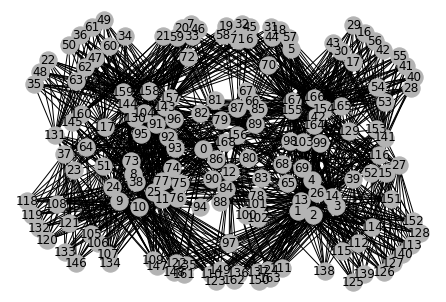

In [18]:
import networkx as nx
nx_G = g.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [19]:
g.number_of_nodes

<bound method DGLBaseGraph.number_of_nodes of DGLGraph(num_nodes=169, num_edges=2968,
         ndata_schemes={'norm': Scheme(shape=(1,), dtype=torch.float32)}
         edata_schemes={})>

#Run the GCN model (AD v MCI)


 EPOCH: 0 **************************************************************************************************** 

Epoch 00000 | Time(s) 0.0107 | Train. Loss 3382.4090 | Training Accuracy 0.5809 | Test Loss 2606.671143 | Test Accuracy 0.6360 ETputs(KTEPS) 276.19

 EPOCH: 1 **************************************************************************************************** 

Epoch 00001 | Time(s) 0.0100 | Train. Loss 832.5024 | Training Accuracy 0.8015 | Test Loss 443.539886 | Test Accuracy 0.7886 ETputs(KTEPS) 296.59

 EPOCH: 2 **************************************************************************************************** 

Epoch 00002 | Time(s) 0.0097 | Train. Loss 533.3777 | Training Accuracy 0.8015 | Test Loss 356.530518 | Test Accuracy 0.8787 ETputs(KTEPS) 306.88

 EPOCH: 3 **************************************************************************************************** 

Epoch 00003 | Time(s) 0.0096 | Train. Loss 79.3612 | Training Accuracy 0.8897 | Test Loss 186.240692 | T

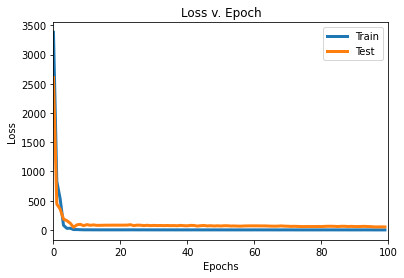

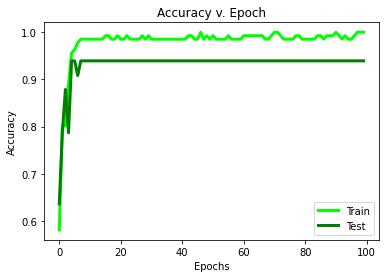

In [20]:
import matplotlib.pyplot as plt
total_test_accuracies = []
total_train_accuracies = []
total_loss = []
total_test_loss = []

if cuda:
    net.cuda()
loss_fcn = torch.nn.CrossEntropyLoss()

# use optimizer
optimizer = torch.optim.Adam(net.parameters(),
                             lr=args.lr,
                            weight_decay=args.weight_decay)
dur = []
sep = '*' * 100
for epoch in range(args.n_epochs):
  traintest_accs = []
  test_accs = []
  loss_val = []
  test_loss_val = []

  
  print("\n EPOCH: {} {} \n".format(epoch, sep))
  for i in range(len(train_ixs)):
        bins = list(range(len(train_ixs)))
        #print("\n Fold: {} {} \n".format(i, sep))
        train_index = []
        traintest_ix = i
        if traintest_ix == max(bins):
            traintest_ix = 0
            bins.remove(traintest_ix)

        else:
            traintest_ix = traintest_ix + 1
            bins.remove(traintest_ix)
            

        
        traintest_index = train_ixs[traintest_ix]
        traintest_index = torch.LongTensor(traintest_index)
        #print(traintest_index)
        #print(test_index)
        for b in bins:
            train_index = np.concatenate((train_index,train_ixs[b]))
        train_index = torch.LongTensor(train_index)
        #print("Train Items:",len(train_index),"\nTest Items:",len(test_index),"\nValidation Items:",len(val_index))
        #print(train_index)

        net.train()

        
        t0 = time.time()
        # forward
        optimizer.zero_grad()
        logits = net(g, features)
        loss = loss_fcn(logits[train_index], labels[train_index])
        
        
        loss.backward()
        optimizer.step()

          
        dur.append(time.time() - t0)
        
        
        traintest_acc = evaluate(net,g,features, labels, traintest_index)
        traintest_accs = np.append(traintest_accs,traintest_acc)
        
        loss_val.append(loss.item())
        
        


  #print(train_index)
  
  for i in range(len(test_ixs)):
    test_index = test_ixs[i]
    test_index = torch.LongTensor(test_index)
    test_loss = loss_fcn(logits[test_index],labels[test_index])
    #print(test_index)
    test_acc = evaluate(net,g,features, labels, test_index)
    test_accs = np.append(test_accs,test_acc)
    test_loss_val.append(test_loss.item())
  print("Epoch {:05d} | Time(s) {:.4f} | Train. Loss {:.4f} | Training Accuracy {:.4f} | Test Loss {:4f} | Test Accuracy {:.4f} "
                "ETputs(KTEPS) {:.2f}". format(epoch, np.mean(dur), np.mean(loss_val),np.mean(traintest_accs),np.mean(test_loss_val),np.mean(test_accs), n_edges / np.mean(dur) / 1000))
  fold_test_avg = np.mean(test_accs)
  fold_train_avg = np.mean(traintest_accs)
  total_test_accuracies = np.append(total_test_accuracies, fold_test_avg)
  total_train_accuracies = np.append(total_train_accuracies, fold_train_avg)
  total_loss = np.append(total_loss,np.mean(loss_val))
  total_test_loss = np.append(total_test_loss,np.mean(test_loss_val))
  
         
 

print("Train Accuracy Avg: {}".format(np.mean(total_train_accuracies[-10:])))
print("Test Accuracy Avg: {}".format(np.mean(total_test_accuracies[-10:])))
print("Final Loss: {}".format(total_loss[-1]))

fig1, ax1 = plt.subplots()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_xlim((0,args.n_epochs))
ax1.plot(range(args.n_epochs),total_loss,linewidth = 3,label = "Train")
ax1.plot(range(args.n_epochs),total_test_loss,linewidth = 3,label = "Test")
ax1.set_title("Loss v. Epoch")
ax1.legend()

fig2, ax2 = plt.subplots()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.plot(range(args.n_epochs),total_train_accuracies,linewidth=3,color='lime',label = "Train")
ax2.plot(range(args.n_epochs),total_test_accuracies,linewidth=3,color='green',label = "Test")
ax2.set_title('Accuracy v. Epoch')
ax2.legend()

plt.show()